In [1]:
# Importing dependencies

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns


pd.set_option('display.max_columns', None)
tf.autograph.set_verbosity(0)

# Data Import

## Concatenating data files
Data files for the period from 2000 to 2005 and data for 2006 onwards are saved in two seperate directories. 
They need to be concatenated to present a full picture. 

In [2]:
dir_1 = 'ACCIDENT'
dir_2 = '2000 to 2005 ACCIDENT'


filenames = ['ACCIDENT_CHAINAGE.csv',
 'ACCIDENT_LOCATION.csv',
 'VEHICLE.csv',
 'NODE_ID_COMPLEX_INT_ID.csv',
 'NODE.csv',
 'ACCIDENT.csv',
 'ACCIDENT_EVENT.csv',
 'SUBDCA.csv',
 'PERSON.csv',
 'ROAD_SURFACE_COND.csv',
 'ATMOSPHERIC_COND.csv']



def concat_dfs(filename):
    df1 = pd.read_csv(dir_1+'/'+filename, dtype = 'unicode')
    df2 = pd.read_csv(dir_2+'/'+filename, dtype = 'unicode')
    if df1.columns.equals(df2.columns):
        result_df = pd.concat([df1, df2], axis=0).reset_index(drop = True)
        print("File {} successfully concatenated.".format(filename))
        return result_df
        
    else:
        print("FILE {}: COLUMN NAMES DO NOT MATCH. FURTHER HANDLING NEEDED.".format(filename))
        
        
df_dic = {}
for f in filenames:
    df_dic[f[:-4].lower()] = concat_dfs(f)
    
# Note that the node files require further handling before they can be concatenated.

File ACCIDENT_CHAINAGE.csv successfully concatenated.
File ACCIDENT_LOCATION.csv successfully concatenated.
File VEHICLE.csv successfully concatenated.
File NODE_ID_COMPLEX_INT_ID.csv successfully concatenated.
FILE NODE.csv: COLUMN NAMES DO NOT MATCH. FURTHER HANDLING NEEDED.
File ACCIDENT.csv successfully concatenated.
File ACCIDENT_EVENT.csv successfully concatenated.
File SUBDCA.csv successfully concatenated.
File PERSON.csv successfully concatenated.
File ROAD_SURFACE_COND.csv successfully concatenated.
File ATMOSPHERIC_COND.csv successfully concatenated.


In [3]:
# The discrepancy is that node_1 dataframe contains an additional column 'LGA_NAME_ALL'. Here it is not included in the concatenated dataframe for consistency.

node_1 = pd.read_csv(dir_1+'/'+ 'NODE.csv', dtype = 'unicode')
node_2 = pd.read_csv(dir_2+'/'+ 'NODE.csv', dtype = 'unicode')
print('Node_1 columns before processing: \n', node_1.columns)
print('Node_2 columns before processing: \n', node_2.columns)


node_1.drop('LGA_NAME_ALL', axis = 1, inplace = True)
node_2.columns = node_1.columns   # Node_2 dataframe columns renamed for consistency.
print('Node_1 columns after processing: \n', node_1.columns)
print('Node_2 columns after processing: \n', node_2.columns)

Node_1 columns before processing: 
 Index(['ACCIDENT_NO', 'NODE_ID', 'NODE_TYPE', 'VICGRID94_X', 'VICGRID94_Y',
       'LGA_NAME', 'LGA_NAME_ALL', 'REGION_NAME', 'DEG_URBAN_NAME', 'Lat',
       'Long', 'POSTCODE_NO'],
      dtype='object')
Node_2 columns before processing: 
 Index(['ACCIDENT_NO', 'NODE_ID', 'NODE_TYPE', 'AMG_X', 'AMG_Y', 'LGA_NAME',
       'Region Name', 'Deg Urban Name', 'Lat', 'Long', 'Postcode No'],
      dtype='object')
Node_1 columns after processing: 
 Index(['ACCIDENT_NO', 'NODE_ID', 'NODE_TYPE', 'VICGRID94_X', 'VICGRID94_Y',
       'LGA_NAME', 'REGION_NAME', 'DEG_URBAN_NAME', 'Lat', 'Long',
       'POSTCODE_NO'],
      dtype='object')
Node_2 columns after processing: 
 Index(['ACCIDENT_NO', 'NODE_ID', 'NODE_TYPE', 'VICGRID94_X', 'VICGRID94_Y',
       'LGA_NAME', 'REGION_NAME', 'DEG_URBAN_NAME', 'Lat', 'Long',
       'POSTCODE_NO'],
      dtype='object')


In [4]:
df_dic['node'] = pd.concat([node_1, node_2], axis=0).reset_index(drop = True)

## Data Quality 
The next step is to inspect the quality of the concatenated data files for missing values, duplication, etc. 

In [5]:
# Dimensions

for k,v in df_dic.items():
    print(f'Dataframe {k} dimensions: {v.shape}')

Dataframe accident_chainage dimensions: (266703, 5)
Dataframe accident_location dimensions: (306769, 11)
Dataframe vehicle dimensions: (550632, 38)
Dataframe node_id_complex_int_id dimensions: (213310, 3)
Dataframe node dimensions: (326413, 11)
Dataframe accident dimensions: (306769, 28)
Dataframe accident_event dimensions: (488631, 13)
Dataframe subdca dimensions: (441765, 4)
Dataframe person dimensions: (759993, 17)
Dataframe road_surface_cond dimensions: (308438, 4)
Dataframe atmospheric_cond dimensions: (310959, 4)


In [6]:
# Dataframe heads

for k,v in df_dic.items():
    
    print(f'\n Dataframe {k}:')

    display(v.head())


 Dataframe accident_chainage:


,Node Id,Route No,Chainage Seq,Route Link No,Chainage
0,4,109454,1,109454801,908
1,4,114095,2,114095801,559
2,6,183250,1,183250801,2536
3,6,216298,2,216298801,528
4,11,2500,1,25008008,801



 Dataframe accident_location:


,ACCIDENT_NO,NODE_ID,ROAD_ROUTE_1,ROAD_NAME,ROAD_TYPE,ROAD_NAME_INT,ROAD_TYPE_INT,DISTANCE_LOCATION,DIRECTION_LOCATION,NEAREST_KM_POST,OFF_ROAD_LOCATION
0,T20060000010,43078,2090,FOSTER,STREET,MCCRAE,STREET,0,SW,NaN,NaN
1,T20060000018,29720,5057,HALLAM,ROAD,BELGRAVE-HALLAM,ROAD,70,S,NaN,NaN
2,T20060000022,203074,9999,BROWNS,ROAD,TRUEMANS,ROAD,210,W,NaN,NaN
3,T20060000023,55462,2400,SPRINGVALE,ROAD,KEYSBOROUGH,AVENUE,0,N,NaN,NaN
4,T20060000026,202988,9999,ELIZABETH,AVENUE,GREENHOOD,CRESCENT,20,N,NaN,NaN



 Dataframe vehicle:


,ACCIDENT_NO,VEHICLE_ID,VEHICLE_YEAR_MANUF,VEHICLE_DCA_CODE,INITIAL_DIRECTION,ROAD_SURFACE_TYPE,Road Surface Type Desc,REG_STATE,VEHICLE_BODY_STYLE,VEHICLE_MAKE,VEHICLE_MODEL,VEHICLE_POWER,VEHICLE_TYPE,Vehicle Type Desc,VEHICLE_WEIGHT,CONSTRUCTION_TYPE,FUEL_TYPE,NO_OF_WHEELS,NO_OF_CYLINDERS,SEATING_CAPACITY,TARE_WEIGHT,TOTAL_NO_OCCUPANTS,CARRY_CAPACITY,CUBIC_CAPACITY,FINAL_DIRECTION,DRIVER_INTENT,VEHICLE_MOVEMENT,TRAILER_TYPE,VEHICLE_COLOUR_1,VEHICLE_COLOUR_2,CAUGHT_FIRE,INITIAL_IMPACT,LAMPS,LEVEL_OF_DAMAGE,OWNER_POSTCODE,TOWED_AWAY_FLAG,TRAFFIC_CONTROL,Traffic Control Desc
0,T20060000010,A,1996,2,SW,1,Paved,V,SEDAN,MITSUB,MAGNA,NaN,01,Car,NaN,,Z,NaN,NaN,NaN,1100,2,1100,NaN,SW,01,01,H,MRN,ZZ,2,F,2,3,3130,1,01,Stop-go lights
1,T20060000010,B,2003,1,NW,1,Paved,V,COUPE,UNKN,GETZ,NaN,01,Car,NaN,,Z,NaN,NaN,NaN,974,1,974,NaN,NE,02,02,H,BLU,ZZ,2,2,2,3,3977,1,01,Stop-go lights
2,T20060000010,C,2001,8,NW,1,Paved,V,SEDAN,FORD,FALCON,NaN,03,Taxi,NaN,,Z,NaN,NaN,NaN,1550,3,1550,NaN,NW,02,02,H,YLW,ZZ,2,F,2,2,3804,2,01,Stop-go lights
3,T20060000018,A,1998,2,S,1,Paved,V,DC UTE,TOYOTA,HILXU,NaN,04,Utility,2730,,Z,NaN,NaN,NaN,1500,1,1230,NaN,S,01,01,H,GRY,ZZ,2,9,0,3,3175,1,00,No control
4,T20060000018,B,1991,1,N,1,Paved,V,SEDAN,SUBARU,LIBER,NaN,01,Car,NaN,,Z,NaN,NaN,NaN,1200,3,1200,NaN,NE,02,02,H,BLU,ZZ,2,F,0,5,3805,1,11,Giveway sign



 Dataframe node_id_complex_int_id:


,ACCIDENT_NO,NODE_ID,COMPLEX_INT_NO
0,T20060000010,43078,NaN
1,T20060000018,29720,NaN
2,T20060000022,203074,NaN
3,T20060000023,55462,NaN
4,T20060000026,202988,NaN



 Dataframe node:


,ACCIDENT_NO,NODE_ID,NODE_TYPE,VICGRID94_X,VICGRID94_Y,LGA_NAME,REGION_NAME,DEG_URBAN_NAME,Lat,Long,POSTCODE_NO
0,T20060002689,22,I,2495701.925,2411599.135,MELBOURNE,METROPOLITAN NORTH WEST REGION,MELB_URBAN,-37.79659639,144.9511968,3051
1,T20060010827,22,I,2495701.925,2411599.135,MELBOURNE,METROPOLITAN NORTH WEST REGION,MELB_URBAN,-37.79659639,144.9511968,3051
2,T20060017279,22,I,2495701.925,2411599.135,MELBOURNE,METROPOLITAN NORTH WEST REGION,MELB_URBAN,-37.79659639,144.9511968,3051
3,T20060041762,22,I,2495701.925,2411599.135,MELBOURNE,METROPOLITAN NORTH WEST REGION,MELB_URBAN,-37.79659639,144.9511968,3051
4,T20060047478,22,I,2495701.925,2411599.135,MELBOURNE,METROPOLITAN NORTH WEST REGION,MELB_URBAN,-37.79659639,144.9511968,3051



 Dataframe accident:


,ACCIDENT_NO,ACCIDENTDATE,ACCIDENTTIME,ACCIDENT_TYPE,Accident Type Desc,DAY_OF_WEEK,Day Week Description,DCA_CODE,DCA Description,DIRECTORY,EDITION,PAGE,GRID_REFERENCE_X,GRID_REFERENCE_Y,LIGHT_CONDITION,Light Condition Desc,NODE_ID,NO_OF_VEHICLES,NO_PERSONS,NO_PERSONS_INJ_2,NO_PERSONS_INJ_3,NO_PERSONS_KILLED,NO_PERSONS_NOT_INJ,POLICE_ATTEND,ROAD_GEOMETRY,Road Geometry Desc,SEVERITY,SPEED_ZONE
0,T20060000010,13/01/2006,12:42:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,40,91A,G,7,1,Day,43078,3,6,0,1,0,5,1,1,Cross intersection,3,060
1,T20060000018,13/01/2006,19:10:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,40,91,H,8,1,Day,29720,2,4,0,1,0,3,1,2,T intersection,3,070
2,T20060000022,14/01/2006,12:10:00,7,Fall from or in moving vehicle,7,Saturday,190,FELL IN/FROM VEHICLE,MEL,40,169,C,11,1,Day,203074,1,2,1,0,0,1,1,5,Not at intersection,2,100
3,T20060000023,14/01/2006,11:49:00,1,Collision with vehicle,7,Saturday,130,REAR END(VEHICLES IN SAME LANE),MEL,40,88,J,8,1,Day,55462,2,2,1,0,0,1,1,2,T intersection,2,080
4,T20060000026,14/01/2006,10:45:00,1,Collision with vehicle,7,Saturday,121,RIGHT THROUGH,MEL,40,169,G,5,1,Day,202988,2,3,0,3,0,0,1,5,Not at intersection,3,050



 Dataframe accident_event:


,ACCIDENT_NO,EVENT_SEQ_NO,EVENT_TYPE,Event Type Desc,VEHICLE_1_ID,VEHICLE_1_COLL_PT,Vehicle 1 Coll Pt Desc,VEHICLE_2_ID,VEHICLE_2_COLL_PT,Vehicle 2 Coll Pt Desc,PERSON_ID,OBJECT_TYPE,Object Type Desc
0,T20060000010,1,C,Collision,B,2,Right side (forwards),A,F,Front,,99,Not Applicable
1,T20060000018,1,C,Collision,B,F,Front,A,9,Not known or Not Applicable,,99,Not Applicable
2,T20060000022,1,2,Fell from vehicle,A,9,Not known or Not Applicable,,,,01,99,Not Applicable
3,T20060000023,1,C,Collision,A,F,Front,B,R,Rear,,99,Not Applicable
4,T20060000026,1,C,Collision,A,9,Not known or Not Applicable,B,9,Not known or Not Applicable,,99,Not Applicable



 Dataframe subdca:


,ACCIDENT_NO,SUB_DCA_CODE,SUB_DCA_SEQ,Sub Dca Code Desc
0,T20060000010,NRQ,1,Not Required
1,T20060000018,NRQ,1,Not Required
2,T20060000022,X02,1,Fell from vehicle
3,T20060000023,A01,2,Vehicle entering intersection
4,T20060000023,N02,1,Mid-block



 Dataframe person:


,ACCIDENT_NO,PERSON_ID,VEHICLE_ID,SEX,AGE,Age Group,INJ_LEVEL,Inj Level Desc,SEATING_POSITION,HELMET_BELT_WORN,ROAD_USER_TYPE,Road User Type Desc,LICENCE_STATE,PEDEST_MOVEMENT,POSTCODE,TAKEN_HOSPITAL,EJECTED_CODE
0,T20060000010,01,A,F,NaN,unknown,4,Not injured,LF,1,3,Passengers,,0,3130,,0
1,T20060000010,02,C,M,43,40-49,4,Not injured,LF,1,3,Passengers,,0,7310,,0
2,T20060000010,03,C,M,22,22-25,4,Not injured,LR,1,3,Passengers,,0,7310,,0
3,T20060000010,A,A,M,72,70+,4,Not injured,D,1,2,Drivers,V,0,3130,,0
4,T20060000010,B,B,F,62,60-64,3,Other injury,D,1,2,Drivers,V,0,NaN,N,0



 Dataframe road_surface_cond:


,ACCIDENT_NO,SURFACE_COND,Surface Cond Desc,SURFACE_COND_SEQ
0,T20060000010,1,Dry,1
1,T20060000018,1,Dry,1
2,T20060000022,1,Dry,1
3,T20060000023,1,Dry,1
4,T20060000026,1,Dry,1



 Dataframe atmospheric_cond:


,ACCIDENT_NO,ATMOSPH_COND,ATMOSPH_COND_SEQ,Atmosph Cond Desc
0,T20060000010,1,1,Clear
1,T20060000018,1,1,Clear
2,T20060000022,1,1,Clear
3,T20060000023,1,1,Clear
4,T20060000026,1,1,Clear


In [7]:
# Missing values
# Missing values in general account for a small percentage in most dataframes, with the exception of a few columns such as 'CUBIC_CAPACITY' in the vehicle dataframe.

print("Percentage of missing values\n")
for k,v in df_dic.items():
    print(f'Missing values in dataframe {k}: (%)')
    print(v.isna().sum()/len(v)*100, '\n')
    


Percentage of missing values

Missing values in dataframe accident_chainage: (%)
Node Id          0.000375
Route No         0.000375
Chainage Seq     0.000375
Route Link No    0.000375
Chainage         0.000375
dtype: float64 

Missing values in dataframe accident_location: (%)
ACCIDENT_NO            0.000000
NODE_ID                0.000000
ROAD_ROUTE_1           0.305442
ROAD_NAME              0.565572
ROAD_TYPE              1.687589
ROAD_NAME_INT          1.001731
ROAD_TYPE_INT          1.547744
DISTANCE_LOCATION      0.305442
DIRECTION_LOCATION     0.305442
NEAREST_KM_POST       99.985331
OFF_ROAD_LOCATION     92.607467
dtype: float64 

Missing values in dataframe vehicle: (%)
ACCIDENT_NO                0.000000
VEHICLE_ID                 0.000000
VEHICLE_YEAR_MANUF         7.165947
VEHICLE_DCA_CODE           0.000000
INITIAL_DIRECTION          0.000000
ROAD_SURFACE_TYPE          0.000000
Road Surface Type Desc     0.000000
REG_STATE                  0.000000
VEHICLE_BODY_STYLE     

In [8]:
# Duplications
# Duplication is present only in the accident_chainage dataframe

print("Duplications\n")
for k,v in df_dic.items():
    print(f'Duplications in dataframe {k}: ')
    print(v.duplicated().sum(), '\n')

Duplications

Duplications in dataframe accident_chainage: 
4206 

Duplications in dataframe accident_location: 
0 

Duplications in dataframe vehicle: 
0 

Duplications in dataframe node_id_complex_int_id: 
0 

Duplications in dataframe node: 
0 

Duplications in dataframe accident: 
0 

Duplications in dataframe accident_event: 
0 

Duplications in dataframe subdca: 
0 

Duplications in dataframe person: 
0 

Duplications in dataframe road_surface_cond: 
0 

Duplications in dataframe atmospheric_cond: 
0 



In [9]:
# Unifying column names

for k,v in df_dic.items():
    v.columns = v.columns.str.replace(' ','_').str.lower()

# Data Preparation
As this project focuses on the injuries of the car accidents, the person dataframe will be used as the base dataframe to merge with the others, including: vehicle, road surface condition, atmosphere condition and accident. The target label, "serious injury", is engineered from the original column "injury level".

In [10]:
# Assigning relevant dataframes to variables for easy reference

accident = df_dic['accident']
person = df_dic['person']
vehicle = df_dic['vehicle']
accident_event = df_dic['accident_event']
road_surface_cond = df_dic['road_surface_cond']
atmospheric_cond = df_dic['atmospheric_cond']


In [11]:
# Creating class PreprocessPerson for data preprocessing

class PreprocessPerson():
    # Creating the target label column
    person['serious_injury'] = person['inj_level'].apply(lambda x: 1 if x == '1' or x == '2' else 0)
    
    def __init__(self):
        self.df = person
        self.merged_with_vehicle = False
        self.merged_with_road_atmosphere = False
        self.merged_with_accident = False
        self.merged_with_accident_event = False
        
    def merge_with_vehicle(self):
        if self.merged_with_vehicle == True:
            print("\nVehicle data already merged.")
        else:
            print("\nDataframe shape: ", self.df.shape)
            vehicle_features = ['accident_no', 'vehicle_id', 'vehicle_year_manuf', 'vehicle_dca_code','road_surface_type', 'road_surface_type_desc',
               'reg_state', 'vehicle_body_style', 'vehicle_make', 'vehicle_model', 'vehicle_type', 'vehicle_type_desc', 'total_no_occupants','trailer_type', 'caught_fire', 'initial_impact', 
               'level_of_damage', 'traffic_control', 'traffic_control_desc']

            print("Shape of data to be merged: ", vehicle[vehicle_features].shape)

            self.df =  pd.merge(self.df, vehicle[vehicle_features], how = 'left', on = ['accident_no','vehicle_id'])
            print("Merge successful. Merged data shape: ", self.df.shape)
            self.merged_with_vehicle = True
            return self.df
        
    def merge_with_road_atmosphere(self):
        if self.merged_with_road_atmosphere == True:
            print("\nRoad and atmosphere data already merged.")
        else:
            print("\nDataframe shape: ", self.df.shape)
            # As some accident may have multiple conditions, all conditions are concatenated. 
            #E.g., 'wet' and 'icy' will become 'wet, icy' under the same accident number.
            road_surface_subset = road_surface_cond.groupby('accident_no')['surface_cond_desc'].agg(lambda x: ', '.join(x)).reset_index()
            print("Shape of data to be merged: ", road_surface_subset.shape)
            self.df = pd.merge(self.df, road_surface_subset, how = 'left', on = 'accident_no')
            
            # Similar to road surface, multiple atmospheric conditions are concatenated
            atmospheric_cond_subset = atmospheric_cond.groupby('accident_no')['atmosph_cond_desc'].agg(lambda x: ', '.join(x)).reset_index()
            print("Shape of data to be merged: ", atmospheric_cond_subset.shape)
            self.df = pd.merge(self.df, atmospheric_cond_subset, how = 'left', on = 'accident_no')
            print("Merge successful. Merged data shape: ", self.df.shape)
            self.merged_with_road_atmosphere = True
            return self.df
        
    def merge_with_accident(self):
        if self.merged_with_accident == True:
            print("\nAccident data already merged.")
        else:
            print("\nDataframe shape: ", self.df.shape)
            accident_features = ['accident_no',  'accident_type','accident_type_desc',  'dca_code','dca_description',  'light_condition', 
                                 'light_condition_desc','node_id', 'police_attend', 'road_geometry', 'road_geometry_desc', 'severity','speed_zone']
            print("Shape of data to be merged: ", accident[accident_features].shape)
            self.df = pd.merge(self.df, accident[accident_features], how = 'left', on = 'accident_no')
            print("Merge successful. Merged data shape: ", self.df.shape)
            self.merged_with_accident = True
            return self.df


## Dataframe after merging with vehicle data

In [12]:
preprocessed_person = PreprocessPerson()  
preprocessed_person.merge_with_vehicle()
preprocessed_person.df.head()


Dataframe shape:  (759993, 18)
Shape of data to be merged:  (550632, 19)
Merge successful. Merged data shape:  (759993, 35)


,accident_no,person_id,vehicle_id,sex,age,age_group,inj_level,inj_level_desc,seating_position,helmet_belt_worn,road_user_type,road_user_type_desc,licence_state,pedest_movement,postcode,taken_hospital,ejected_code,serious_injury,vehicle_year_manuf,vehicle_dca_code,road_surface_type,road_surface_type_desc,reg_state,vehicle_body_style,vehicle_make,vehicle_model,vehicle_type,vehicle_type_desc,total_no_occupants,trailer_type,caught_fire,initial_impact,level_of_damage,traffic_control,traffic_control_desc
0,T20060000010,01,A,F,NaN,unknown,4,Not injured,LF,1,3,Passengers,,0,3130,,0,0,1996,2,1,Paved,V,SEDAN,MITSUB,MAGNA,01,Car,2,H,2,F,3,01,Stop-go lights
1,T20060000010,02,C,M,43,40-49,4,Not injured,LF,1,3,Passengers,,0,7310,,0,0,2001,8,1,Paved,V,SEDAN,FORD,FALCON,03,Taxi,3,H,2,F,2,01,Stop-go lights
2,T20060000010,03,C,M,22,22-25,4,Not injured,LR,1,3,Passengers,,0,7310,,0,0,2001,8,1,Paved,V,SEDAN,FORD,FALCON,03,Taxi,3,H,2,F,2,01,Stop-go lights
3,T20060000010,A,A,M,72,70+,4,Not injured,D,1,2,Drivers,V,0,3130,,0,0,1996,2,1,Paved,V,SEDAN,MITSUB,MAGNA,01,Car,2,H,2,F,3,01,Stop-go lights
4,T20060000010,B,B,F,62,60-64,3,Other injury,D,1,2,Drivers,V,0,NaN,N,0,0,2003,1,1,Paved,V,COUPE,UNKN,GETZ,01,Car,1,H,2,2,3,01,Stop-go lights


## Dataframe after merging with road surface and atmospheric condition data

In [13]:
preprocessed_person.merge_with_road_atmosphere()
preprocessed_person.df.head()


Dataframe shape:  (759993, 35)
Shape of data to be merged:  (306769, 2)
Shape of data to be merged:  (306769, 2)
Merge successful. Merged data shape:  (759993, 37)


,accident_no,person_id,vehicle_id,sex,age,age_group,inj_level,inj_level_desc,seating_position,helmet_belt_worn,road_user_type,road_user_type_desc,licence_state,pedest_movement,postcode,taken_hospital,ejected_code,serious_injury,vehicle_year_manuf,vehicle_dca_code,road_surface_type,road_surface_type_desc,reg_state,vehicle_body_style,vehicle_make,vehicle_model,vehicle_type,vehicle_type_desc,total_no_occupants,trailer_type,caught_fire,initial_impact,level_of_damage,traffic_control,traffic_control_desc,surface_cond_desc,atmosph_cond_desc
0,T20060000010,01,A,F,NaN,unknown,4,Not injured,LF,1,3,Passengers,,0,3130,,0,0,1996,2,1,Paved,V,SEDAN,MITSUB,MAGNA,01,Car,2,H,2,F,3,01,Stop-go lights,Dry,Clear
1,T20060000010,02,C,M,43,40-49,4,Not injured,LF,1,3,Passengers,,0,7310,,0,0,2001,8,1,Paved,V,SEDAN,FORD,FALCON,03,Taxi,3,H,2,F,2,01,Stop-go lights,Dry,Clear
2,T20060000010,03,C,M,22,22-25,4,Not injured,LR,1,3,Passengers,,0,7310,,0,0,2001,8,1,Paved,V,SEDAN,FORD,FALCON,03,Taxi,3,H,2,F,2,01,Stop-go lights,Dry,Clear
3,T20060000010,A,A,M,72,70+,4,Not injured,D,1,2,Drivers,V,0,3130,,0,0,1996,2,1,Paved,V,SEDAN,MITSUB,MAGNA,01,Car,2,H,2,F,3,01,Stop-go lights,Dry,Clear
4,T20060000010,B,B,F,62,60-64,3,Other injury,D,1,2,Drivers,V,0,NaN,N,0,0,2003,1,1,Paved,V,COUPE,UNKN,GETZ,01,Car,1,H,2,2,3,01,Stop-go lights,Dry,Clear


## Dataframe after merging with accident data

In [14]:
preprocessed_person.merge_with_accident()
preprocessed_person.df.head()


Dataframe shape:  (759993, 37)
Shape of data to be merged:  (306769, 13)
Merge successful. Merged data shape:  (759993, 49)


,accident_no,person_id,vehicle_id,sex,age,age_group,inj_level,inj_level_desc,seating_position,helmet_belt_worn,road_user_type,road_user_type_desc,licence_state,pedest_movement,postcode,taken_hospital,ejected_code,serious_injury,vehicle_year_manuf,vehicle_dca_code,road_surface_type,road_surface_type_desc,reg_state,vehicle_body_style,vehicle_make,vehicle_model,vehicle_type,vehicle_type_desc,total_no_occupants,trailer_type,caught_fire,initial_impact,level_of_damage,traffic_control,traffic_control_desc,surface_cond_desc,atmosph_cond_desc,accident_type,accident_type_desc,dca_code,dca_description,light_condition,light_condition_desc,node_id,police_attend,road_geometry,road_geometry_desc,severity,speed_zone
0,T20060000010,01,A,F,NaN,unknown,4,Not injured,LF,1,3,Passengers,,0,3130,,0,0,1996,2,1,Paved,V,SEDAN,MITSUB,MAGNA,01,Car,2,H,2,F,3,01,Stop-go lights,Dry,Clear,1,Collision with vehicle,113,RIGHT NEAR (INTERSECTIONS ONLY),1,Day,43078,1,1,Cross intersection,3,060
1,T20060000010,02,C,M,43,40-49,4,Not injured,LF,1,3,Passengers,,0,7310,,0,0,2001,8,1,Paved,V,SEDAN,FORD,FALCON,03,Taxi,3,H,2,F,2,01,Stop-go lights,Dry,Clear,1,Collision with vehicle,113,RIGHT NEAR (INTERSECTIONS ONLY),1,Day,43078,1,1,Cross intersection,3,060
2,T20060000010,03,C,M,22,22-25,4,Not injured,LR,1,3,Passengers,,0,7310,,0,0,2001,8,1,Paved,V,SEDAN,FORD,FALCON,03,Taxi,3,H,2,F,2,01,Stop-go lights,Dry,Clear,1,Collision with vehicle,113,RIGHT NEAR (INTERSECTIONS ONLY),1,Day,43078,1,1,Cross intersection,3,060
3,T20060000010,A,A,M,72,70+,4,Not injured,D,1,2,Drivers,V,0,3130,,0,0,1996,2,1,Paved,V,SEDAN,MITSUB,MAGNA,01,Car,2,H,2,F,3,01,Stop-go lights,Dry,Clear,1,Collision with vehicle,113,RIGHT NEAR (INTERSECTIONS ONLY),1,Day,43078,1,1,Cross intersection,3,060
4,T20060000010,B,B,F,62,60-64,3,Other injury,D,1,2,Drivers,V,0,NaN,N,0,0,2003,1,1,Paved,V,COUPE,UNKN,GETZ,01,Car,1,H,2,2,3,01,Stop-go lights,Dry,Clear,1,Collision with vehicle,113,RIGHT NEAR (INTERSECTIONS ONLY),1,Day,43078,1,1,Cross intersection,3,060


# EDA

In [15]:
number_of_accidents = len(accident['accident_no'].unique())
print('Number of car accidents recorded: ', number_of_accidents)

Number of car accidents recorded:  306769


In [16]:
number_of_people_involved = len(person)
print('Number of people involved in car accidents: ', number_of_people_involved)

number_of_people_injured = len(person[person['inj_level'].isin(['1','2','3'])])   # injurey level 4 is 'no injury'
print('Number of people injured in car accidents: ', number_of_people_injured)

number_of_people_seriously_injured = len(person[person['inj_level'].isin(['1','2'])])   
print('Number of people seriously injured in car accidents: ', number_of_people_seriously_injured)

Number of people involved in car accidents:  759993
Number of people injured in car accidents:  408549
Number of people seriously injured in car accidents:  125507


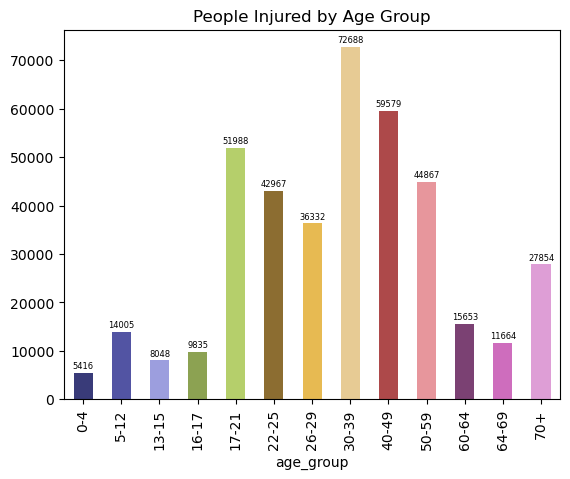

In [17]:
def plot_injured_by_age_group():
    injured = person[person['inj_level'].isin(['1','2','3'])]
    injured_by_age = injured.groupby('age_group')['accident_no'].count().drop('unknown').reset_index()
    injured_by_age = injured_by_age.reindex([0,8,1,2,3,4,5,6,7,9,10,11,12])
    injured_by_age.set_index('age_group', inplace = True)
    
    fig, ax = plt.subplots()
    colors = plt.cm.tab20b(np.linspace(0, 1, len(injured_by_age)))
    
    ax = injured_by_age['accident_no'].plot(kind = 'bar', color = colors)
    ax.set_title('People Injured by Age Group')
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=6, color='black', xytext=(0, 5), textcoords='offset points')
    return fig


plot_injured_by_age_group = plot_injured_by_age_group()

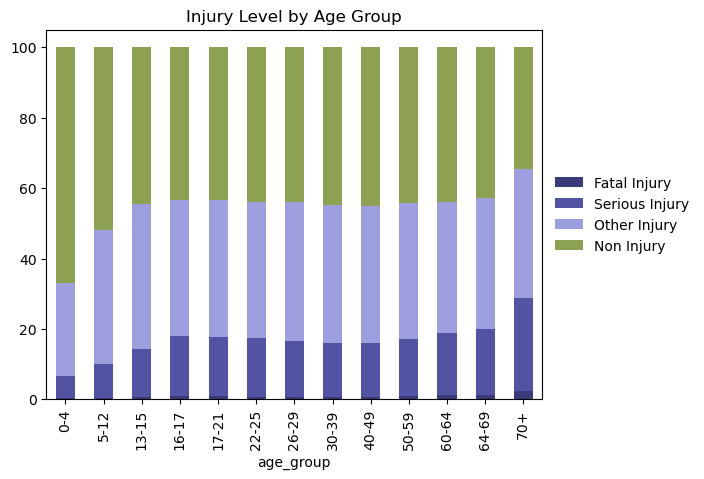

In [18]:
def plot_injury_by_age_group():
    injured = person[person['inj_level'].isin(['1','2','3','4'])]
    injury_level_by_age = injured.groupby(['age_group','inj_level'])['accident_no'].count().drop('unknown').reset_index()
    pivot = pd.pivot_table(data = injury_level_by_age, index = ['age_group'], columns = 'inj_level', values = 'accident_no')
    tot = pivot.sum(axis = 1)
    per = pivot.div(tot, axis = 0).mul(100).round(2)
    per = per.reindex(['0-4', '5-12', '13-15', '16-17', '17-21', '22-25', '26-29', '30-39', '40-49','50-59', '60-64', '64-69', '70+'])

    
    colors = plt.cm.tab20b(np.linspace(0,1,len(per)))

    ax = per.plot(kind='bar', stacked=True, color = colors)
    ax.legend(['Fatal Injury','Serious Injury','Other Injury','Non Injury'], bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
    ax.set_title("Injury Level by Age Group")


plot_injury_by_age_group = plot_injury_by_age_group()


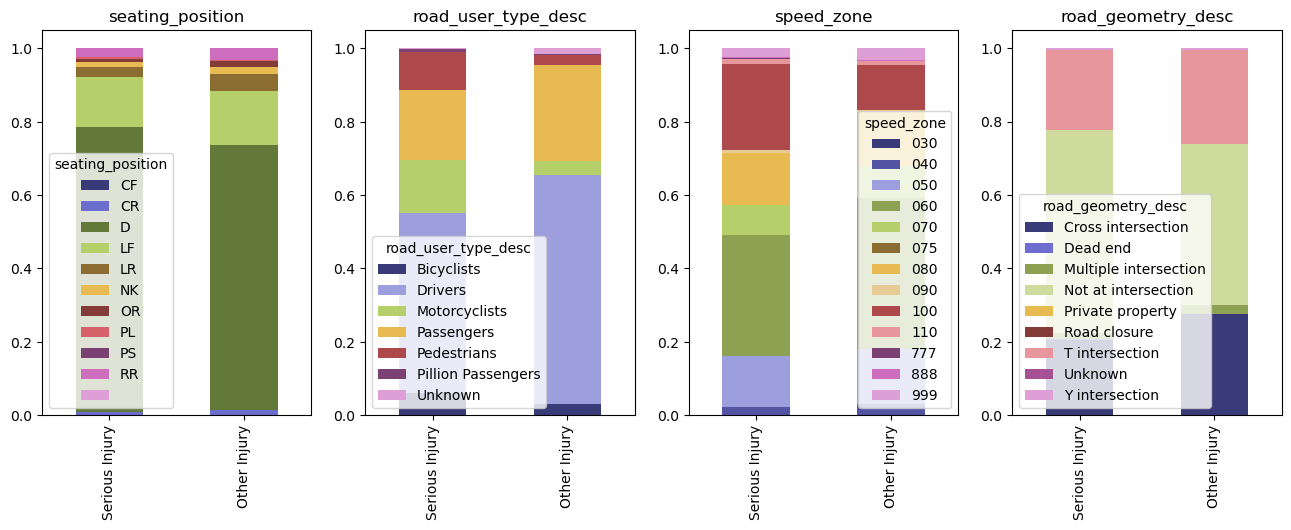

In [19]:
def plot_serious_injuries():
    plot_cols = ['seating_position','road_user_type_desc','speed_zone','road_geometry_desc']

    fig, axes = plt.subplots(figsize = (16,5), nrows=1, ncols=len(plot_cols))

    for i in range(0,len(plot_cols)):
        subdf_1 = pd.Series(preprocessed_person.df[preprocessed_person.df.serious_injury==1].groupby(plot_cols[i]).count()['serious_injury'],
                            name = 'Serious Injury')
        tot_1 = sum(subdf_1)
        subdf_2 = pd.Series(preprocessed_person.df[preprocessed_person.df.serious_injury==0].groupby(plot_cols[i]).count()['serious_injury'],
                            name = 'Other Injury')
        tot_2 = sum(subdf_2)
        subdf = pd.DataFrame([subdf_1/tot_1, subdf_2/tot_2])

        colors = plt.cm.tab20b(np.linspace(0,1,subdf.shape[1]))
        subdf.plot.bar(stacked = True, ax = axes[i], title = plot_cols[i], color = colors )
        
    return fig

plot_serious_injuries = plot_serious_injuries()



# Building the Model

The number of input features is further streamlined. As tensorflow's decision forest model, which can natively handle categoical data, is to be used, there is no need to further process the categorical data such as one-hot encoding, etc.

Reference: "Numerical features do not need to be normalized. Categorical string values do not need to be encoded in a dictionary." https://www.tensorflow.org/decision_forests/tutorials/beginner_colab#re-train_the_model_with_a_different_learning_algorithm

## Preparing training data

In [20]:
input_features = [ 'sex', 'age_group','seating_position', 'helmet_belt_worn', 'road_user_type_desc', 
       'pedest_movement',  'ejected_code','vehicle_year_manuf', 'vehicle_dca_code', 
       'road_surface_type_desc', 'vehicle_body_style', 'vehicle_make', 'vehicle_model', 
       'vehicle_type_desc', 'total_no_occupants','caught_fire', 'initial_impact',
       'level_of_damage', 'traffic_control_desc', 'surface_cond_desc',
       'atmosph_cond_desc', 'accident_type_desc', 
       'dca_description',   'light_condition_desc', 'road_geometry_desc', 'speed_zone']

label = 'serious_injury'

training_data = preprocessed_person.df.copy()[input_features+[label]]

### Handling missing values

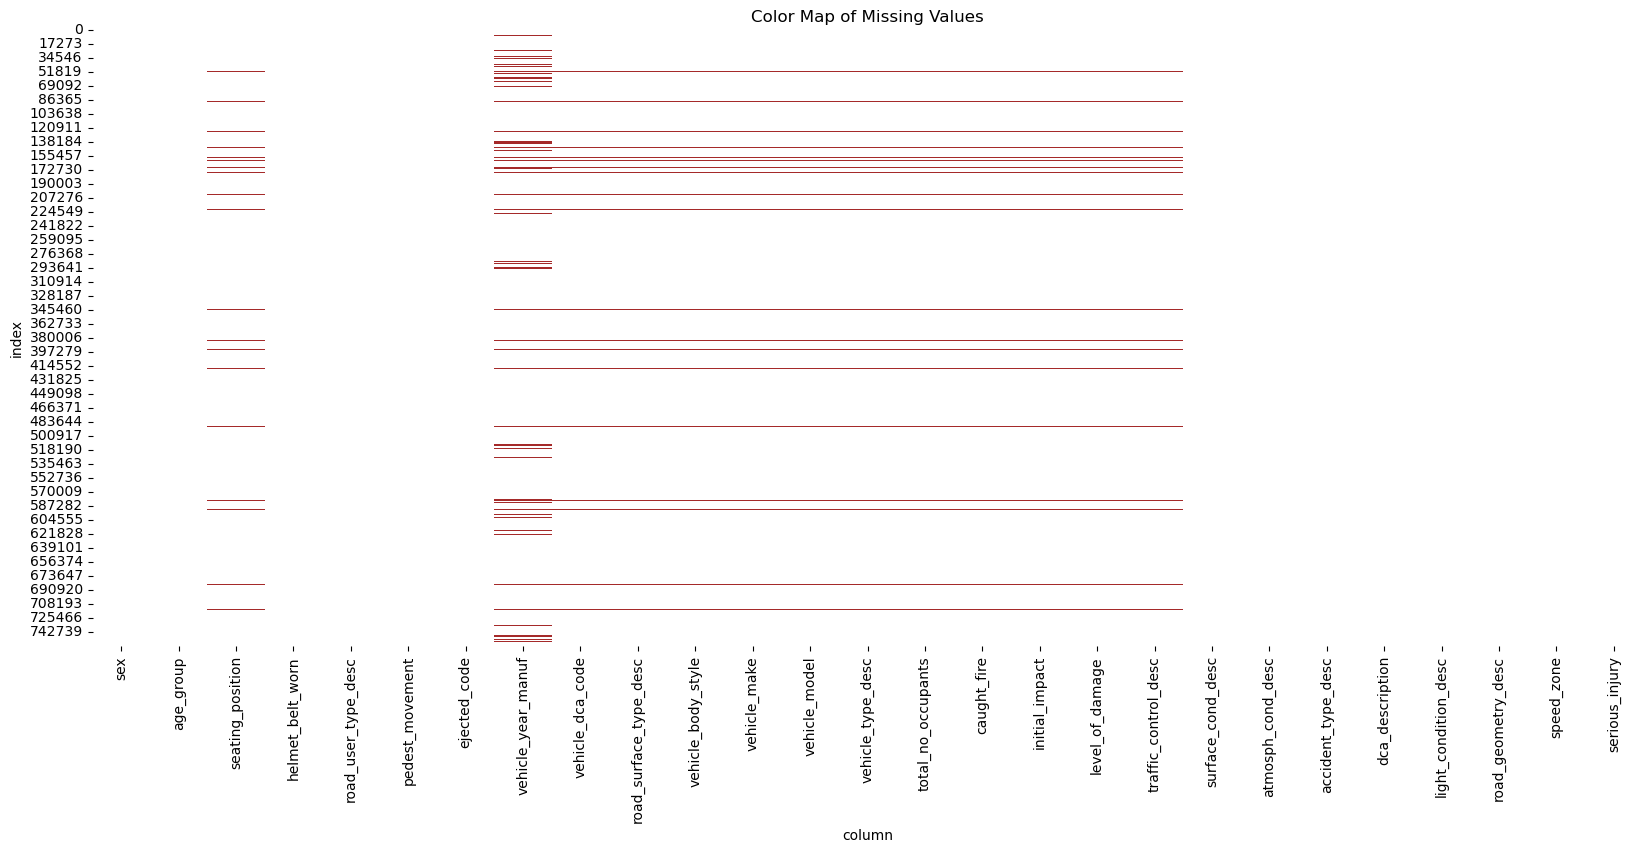

In [21]:
# Visualising missing values

plt.figure(figsize=(20,8))
sns.heatmap(training_data.isna(), cbar=False, cmap=sns.color_palette(['white','brown'], as_cmap=True))
plt.ylabel('index')
plt.xlabel('column')
plt.title('Color Map of Missing Values') 
plt.savefig('Missing Values')

In [22]:
print("Percentage of missing values in training data: \n", training_data.isna().sum()/len(training_data))

Percentage of missing values in training data: 
 sex                       0.000000
age_group                 0.000000
seating_position          0.041729
helmet_belt_worn          0.000000
road_user_type_desc       0.000000
pedest_movement           0.000000
ejected_code              0.000000
vehicle_year_manuf        0.099573
vehicle_dca_code          0.041711
road_surface_type_desc    0.041711
vehicle_body_style        0.041711
vehicle_make              0.041711
vehicle_model             0.041711
vehicle_type_desc         0.041711
total_no_occupants        0.041712
caught_fire               0.041711
initial_impact            0.041711
level_of_damage           0.041711
traffic_control_desc      0.041711
surface_cond_desc         0.000000
atmosph_cond_desc         0.000000
accident_type_desc        0.000000
dca_description           0.000000
light_condition_desc      0.000000
road_geometry_desc        0.000000
speed_zone                0.000000
serious_injury            0.000000
dtype:

In [23]:
print('Training data shape (before removing missing values): ', training_data.shape)
training_data.dropna(how = 'any',inplace = True)
print('Training data shape (after removing missing values): ', training_data.shape)

Training data shape (before removing missing values):  (759993, 27)
Training data shape (after removing missing values):  (684256, 27)


In [24]:
print("Percentage of missing values in training data: \n", training_data.isna().sum()/len(training_data))

Percentage of missing values in training data: 
 sex                       0.0
age_group                 0.0
seating_position          0.0
helmet_belt_worn          0.0
road_user_type_desc       0.0
pedest_movement           0.0
ejected_code              0.0
vehicle_year_manuf        0.0
vehicle_dca_code          0.0
road_surface_type_desc    0.0
vehicle_body_style        0.0
vehicle_make              0.0
vehicle_model             0.0
vehicle_type_desc         0.0
total_no_occupants        0.0
caught_fire               0.0
initial_impact            0.0
level_of_damage           0.0
traffic_control_desc      0.0
surface_cond_desc         0.0
atmosph_cond_desc         0.0
accident_type_desc        0.0
dca_description           0.0
light_condition_desc      0.0
road_geometry_desc        0.0
speed_zone                0.0
serious_injury            0.0
dtype: float64


### Handling class imbalance

In [25]:
print('Checking for class imbalance: \n', training_data['serious_injury'].value_counts()/len(training_data))

Checking for class imbalance: 
 0    0.848489
1    0.151511
Name: serious_injury, dtype: float64


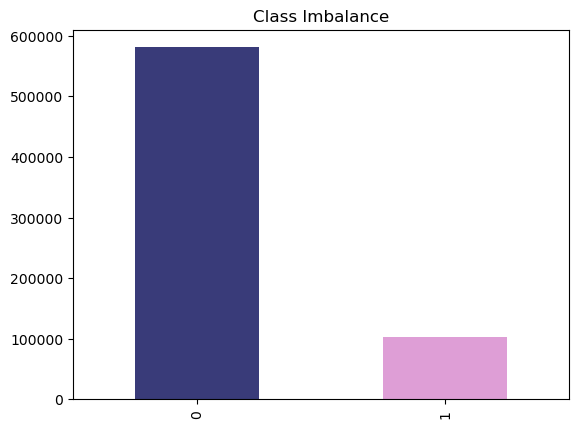

In [26]:
# Visualising class imbalance

fig, ax = plt.subplots()
colors = plt.cm.tab20b(np.linspace(0, 1, 2))
ax = training_data['serious_injury'].value_counts().plot(kind = 'bar', color = colors)
ax.set_title('Class Imbalance')
plt.savefig('Class Imbalance')

In [ ]:
training_logs = tuned_model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in training_logs], [log.evaluation.accuracy for log in training_logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in training_logs], [log.evaluation.loss for log in training_logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss")
plt.savefig('num_of_trees.png')

In [27]:
# Under sampling class 0 so that class distribution is balanced

class_0_count, class_1_count = training_data['serious_injury'].value_counts()

class_0 = training_data[training_data['serious_injury'] == 0]
class_1 = training_data[training_data['serious_injury'] == 1]

print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class_0_under = class_0.sample(class_1_count)

training_data_new = pd.concat([class_0_under, class_1], axis=0)

train_df = training_data_new.sample(frac=0.8, random_state=42)
test_df = training_data_new.drop(train_df.index)

# Converting to keras data form
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df,label = label, fix_feature_names = False)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label = label, fix_feature_names = False)

class 0: (580584, 27)
class 1: (103672, 27)


## Running the base model

In [28]:
%%time

# Training the base model with gradient boosted trees
tf.keras.backend.clear_session()

model = tfdf.keras.GradientBoostedTreesModel(
    verbose=1, 
    features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
    exclude_non_specified_features=True, 
)
model.fit(train_ds)



Use /var/folders/3g/9p31z_5j07s2m9ndd_kdfcfr0000gn/T/tmp2lx763op as temporary training directory
Reading training dataset...


[WARNING 23-09-15 09:51:50.6285 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-15 09:51:50.6298 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-15 09:51:50.6298 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:02.059765. Found 165875 examples.
Training model...
Model trained in 0:02:17.959074
Compiling model...


[INFO 23-09-15 09:54:10.6418 AEST kernel.cc:1243] Loading model from path /var/folders/3g/9p31z_5j07s2m9ndd_kdfcfr0000gn/T/tmp2lx763op/model/ with prefix 2b5109931b9148bd
[INFO 23-09-15 09:54:10.6532 AEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-09-15 09:54:10.6532 AEST kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model compiled.
CPU times: user 2min 27s, sys: 6.06 s, total: 2min 33s
Wall time: 2min 20s


In [29]:
# Base model validation and test accuracy

self_evaluation = model.make_inspector().evaluation()
print(f"Validation accuracy: {self_evaluation.accuracy} Loss:{self_evaluation.loss}\n")

model.compile(metrics=["accuracy"])
evaluation = model.evaluate(test_ds, return_dict=True)
print(f"Test accuracy :{evaluation['accuracy']}")

Validation accuracy: 0.7584497332572937 Loss:0.9912293553352356

42/42 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.7662
Test accuracy :0.7661626935005188


# Parameter Tuning and Evaluation

## Automated parameter tuning

In [30]:
%%time

# Running tensorflow dicision forest's inbuilt automated parameter tuning
tuner = tfdf.tuner.RandomSearch(num_trials=50, use_predefined_hps=True)

tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
tuned_model.fit(train_ds, verbose=1)

Use /var/folders/3g/9p31z_5j07s2m9ndd_kdfcfr0000gn/T/tmpvc6fookd as temporary training directory
Reading training dataset...


[WARNING 23-09-15 09:54:11.6298 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-15 09:54:11.6298 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-15 09:54:11.6298 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.629950. Found 165875 examples.
Training model...
Model trained in 0:00:11.935675
Compiling model...
Model compiled.
CPU times: user 1min 52s, sys: 499 ms, total: 1min 52s
Wall time: 12.7 s


[INFO 23-09-15 09:54:24.1948 AEST kernel.cc:1243] Loading model from path /var/folders/3g/9p31z_5j07s2m9ndd_kdfcfr0000gn/T/tmpvc6fookd/model/ with prefix e5a22150b0534a0c
[INFO 23-09-15 09:54:24.1973 AEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-09-15 09:54:24.1973 AEST kernel.cc:1075] Use fast generic engine


In [31]:
# Tuned model test accuracy

tuned_model.compile(["accuracy"])
tuned_test_accuracy = tuned_model.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
print(f"Test accuracy with the TF-DF hyper-parameter tuner: {tuned_test_accuracy:.4f}")

Test accuracy with the TF-DF hyper-parameter tuner: 0.7556


In [32]:
# Tuned model hyperparameters

tuning_logs = tuned_model.make_inspector().tuning_logs()
tuning_logs[tuning_logs.best].iloc[0]

score                                               -1.073029
evaluation_time                                      8.755245
best                                                     True
split_axis                                     SPARSE_OBLIQUE
sparse_oblique_projection_density_factor                  1.0
sparse_oblique_normalization                             NONE
sparse_oblique_weights                                 BINARY
categorical_algorithm                                    CART
growing_strategy                            BEST_FIRST_GLOBAL
max_num_nodes                                              64
sampling_method                                        RANDOM
subsample                                                 1.0
shrinkage                                                 0.1
min_examples                                               20
use_hessian_gain                                        false
num_candidate_attributes_ratio                            0.2
Name: 0,

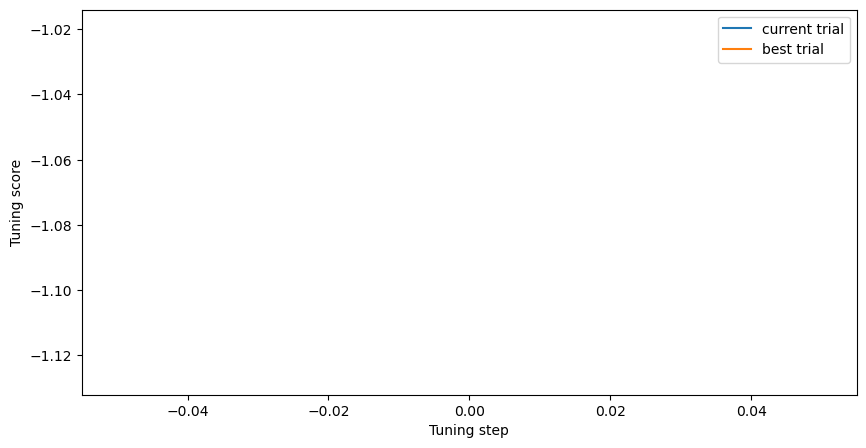

In [33]:
#  Visualizing the training log

plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.savefig('tuningstep.png')

## Feature importance

In [34]:
feature_importances = tuned_model.make_inspector().variable_importances()
for k in feature_importances.keys():
    print(k)
    print([x[0][0] for x in feature_importances[k][:5]])
    

INV_MEAN_MIN_DEPTH
['level_of_damage', 'dca_description', 'helmet_belt_worn', 'accident_type_desc', 'ejected_code']
NUM_AS_ROOT
['level_of_damage', 'accident_type_desc', 'helmet_belt_worn', 'ejected_code', 'speed_zone']
SUM_SCORE
['level_of_damage', 'dca_description', 'road_user_type_desc', 'accident_type_desc', 'helmet_belt_worn']
NUM_NODES
['dca_description', 'vehicle_year_manuf', 'vehicle_make', 'level_of_damage', 'age_group']


## Model Performance

In [35]:
# Model Evaluation
proba_serious_injury = tuned_model.predict(test_ds)
pred_serious_injury = (proba_serious_injury >= 0.5).astype(int)
true_serious_injury = tf.concat([y for x, y in test_ds], axis=0)

report = classification_report(true_serious_injury, pred_serious_injury)
accuracy = accuracy_score(true_serious_injury, pred_serious_injury).round(4)
f1 = f1_score(true_serious_injury, pred_serious_injury).round(4)
precision = precision_score(true_serious_injury, pred_serious_injury).round(4)
recall = recall_score(true_serious_injury, pred_serious_injury).round(4)

print(report)
print("Tuned model accuracy: ", accuracy)
print("Tuned model F1: ", f1)
print("Tuned model precision: ", precision)
print("Tuned model recall: ", recall)

42/42 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     20789
           1       0.74      0.78      0.76     20680

    accuracy                           0.76     41469
   macro avg       0.76      0.76      0.76     41469
weighted avg       0.76      0.76      0.76     41469

Tuned model accuracy:  0.7556
Tuned model F1:  0.7614
Tuned model precision:  0.742
Tuned model recall:  0.7818


## Confnusion Matrix

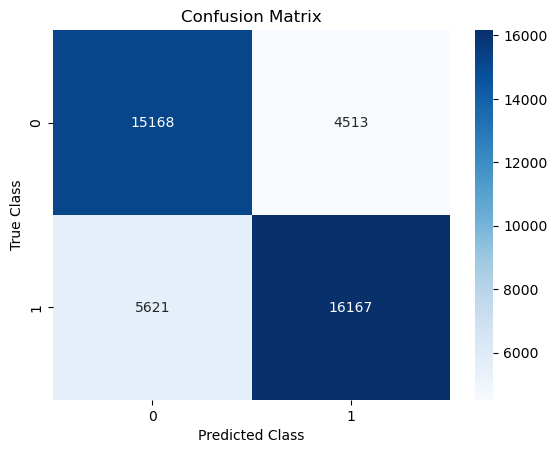

In [36]:
cm = confusion_matrix(pred_serious_injury, true_serious_injury)

fig, ax = plt.subplots()

sns.heatmap(cm, annot=True, cmap='Blues', fmt = 'g', ax = ax)
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Class')
ax.set_xlabel('Predicted Class')
plt.savefig('cm.jpg')

## Making Predictions

In [38]:
def make_prediction(df):
    ds = tfdf.keras.pd_dataframe_to_tf_dataset(df)
    proba_serious_injury = tuned_model.predict(ds, verbose = 0)
    pred_serious_injury = (proba_serious_injury >= 0.5).astype(int)[0][0]

    print('Predicted class: ',pred_serious_injury)
    return pred_serious_injury

example_prediction = make_prediction(test_df.sample(1))


Predicted class:  1


In [37]:
# Inspecting the tuned model

tuned_model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (26):
	accident_type_desc
	age_group
	atmosph_cond_desc
	caught_fire
	dca_description
	ejected_code
	helmet_belt_worn
	initial_impact
	level_of_damage
	light_condition_desc
	pedest_movement
	road_geometry_desc
	road_surface_type_desc
	road_user_type_desc
	seating_position
	sex
	speed_zone
	surface_cond_desc
	total_no_occupants
	traffic_control_desc
	vehicle_body_style
	vehicle_dca_code
	vehicle_make
	vehicle_model
	vehicle_type_desc
	vehicle_year_manuf

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.        "level_of_damage"  0.300580 ################
    2.     

## Parameter tuning (manual)

In [ ]:
%%time


tf.keras.backend.clear_session()

tuner = tfdf.tuner.RandomSearch(num_trials=1000)
tuner.choice("min_examples", [2, 5, 7, 10])
tuner.choice("categorical_algorithm", ["CART", "RANDOM"])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [3, 4, 5, 6, 8])

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])

tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15])
tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0])

tuner.choice("split_axis", ["AXIS_ALIGNED"])
oblique_space = tuner.choice("split_axis", ["SPARSE_OBLIQUE"], merge=True)
oblique_space.choice("sparse_oblique_normalization",
                     ["NONE", "STANDARD_DEVIATION", "MIN_MAX"])
oblique_space.choice("sparse_oblique_weights", ["BINARY", "CONTINUOUS"])
oblique_space.choice("sparse_oblique_num_projections_exponent", [1.0, 1.5])

manual_tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
manual_tuned_model.fit(train_ds, verbose=1)

tuned_self_evaluation = manual_tuned_model.make_inspector().evaluation()
print(f"Accuracy: {tuned_self_evaluation.accuracy} Loss:{tuned_self_evaluation.loss}")
